detecting...
frameOffset = 5410   icon_ind = 1   #good = 11


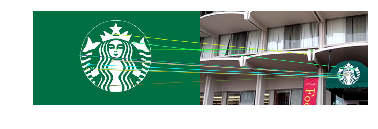

frameOffset = 5429   icon_ind = 0   #good = 11


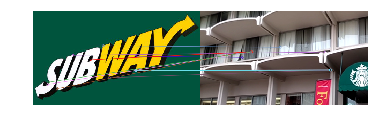

frameOffset = 5550   icon_ind = 1   #good = 11


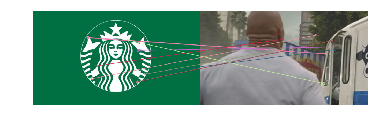

Detection finished in 34.1865747263746 seconds.


[[1, 5411], [0, 5430], [1, 5551]]

In [38]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time

def cut_copy_image(img, size, corner):
    # initialization
    width = 480
    height = 270
    cWidth = size[0]
    cHeight = size[1]
    
    frameSize = width*height
    framOffsetWidth = corner[0]
    framOffsetHeight = corner[1]
    lineSkip = width-cWidth
    
    
    cut = np.full((cHeight,cWidth,3), 0, np.uint8)
    
    # cut-copy image
    ind = framOffsetWidth + framOffsetHeight*width
    for y in range(cHeight):
        for x in range(cWidth):
            cut[y][x] = [img[ind], img[ind + frameSize], img[ind + frameSize*2]]
            ind += 1
        ind += lineSkip
    return cut



def icon_detect(videoPath, iconIndexSet, threshHold=10, passLine=0.75, start=0, end=10, imshow=True, corner=[0,0], zoomProp=1/6):
    begin = time.clock()
    # Initialization
    width = 480
    height = 270
    frameOffset = 0
    frameLength = width * height * 3
    position = frameOffset * frameLength
    frameRate = 30
    size = [-1, -1]

    ## frameTemplatePath = [r'./data/mcdonalds_logo.jpg', r'./data/subway_snapshoot_2_zoomed.jpg']
    iconSet = [ np.array(Image.open(iconPath)) for iconPath in iconPathSet ]
    iconInfoSet = []

    # Pre-process on brand-icons
    orb = cv2.ORB_create()
    for iconInd in iconIndexSet:
        icon = iconSet[iconInd]
        kpi, desi = orb.detectAndCompute(icon,None)
        iconInfoSet.append([kpi, desi])


    # Laod the .rgb video file into Memory
    file = open(videoPath, 'rb')    ## consider the opne-mode!

    # Detect brand-icons in video
    print("detecting...")
    ans = []
    frameOffset = start*30
    frameSize = width * height
    pWidth = int(width * (1-2*zoomProp))
    pHeight = int(height * (1-2*zoomProp))
    frameArr = np.full((180,320,3), 0, np.uint8)
    while frameOffset <= end*30:
        # locate & laod frame
        file.seek(position, 0)
        frameByte = file.read(frameLength)

        frameOffset += 1
        position = frameOffset * frameLength

        # transfer .rgb frame
        size[0] = pWidth
        size[1] = pHeight
        frameArr = cut_copy_image(frameByte, size, corner)
        
        # get key-point info of current-frame
        alignFrameArr = cv2.resize(frameArr, (480, 270), interpolation=cv2.INTER_CUBIC)
        kpf, desf = orb.detectAndCompute(alignFrameArr,None)

        # compare with brand-icon info
        bf = cv2.BFMatcher()
        for iconInfo in iconInfoSet:
            matches = bf.knnMatch(iconInfo[1],desf, k=2)  ## what is 'k'?
            good = []
            for m,n in matches:
                if m.distance < passLine*n.distance:
                    good.append([m])
            # Continue zoom-in 
            if len(good) >= threshHold:
                if imshow:
                    print("frameOffset =", frameOffset-1, "  icon_ind =", iconInfoSet.index(iconInfo), "  #good =", len(good))
                    matchCompImg = cv2.drawMatchesKnn(iconSet[ iconIndexSet[ iconInfoSet.index(iconInfo)] ], iconInfo[0], alignFrameArr, kpf, good, None, flags=2)  ## what is 'flags'?
                    plt.figure("matchCompImg"); plt.imshow(matchCompImg); plt.axis('off'); plt.show()
                
                ans.append( [iconInfoSet.index(iconInfo), frameOffset] )
    
    # Return
    print("Detection finished in {} seconds.".format(time.clock()-begin))
    return ans


## icon_detect(videoPath=r'./data/data_test1.rgb', iconIndexSet=[0,1], threshHold=12, passLine=0.75, start=65, end=75, imshow=True, zoom=True)
## icon_detect(videoPath=r'./data/data_test1.rgb', iconIndexSet=[0,1], threshHold=12, passLine=0.75, start=170, end=185, imshow=True, zoom=False)
icon_detect(videoPath=r'./data/data_test1.rgb', iconIndexSet=[0,1], threshHold=11, passLine=0.75, start=170, end=185, imshow=True)

## icon_detect(videoPath=r'./data/data_test2.rgb', iconIndexSet=[2,3], threshHold=7, passLine=0.75, start=65, end=75, imshow=True)
## icon_detect(videoPath=r'./data/data_test2.rgb', iconIndexSet=[2,3], threshHold=12, passLine=0.75, start=140, end=150, imshow=True)
